# 📊 Estimación de $p_c$, Clúster Máximo y Clúster Medio
Este notebook estima:
- El valor crítico de percolación \( p_c \)
- El tamaño del clúster máximo
- El tamaño del clúster medio
mediante simulaciones múltiples del modelo de percolación.

p_c (cruce 0.5) ≈ 0.5476
χ_t(p_c) (cluster medio raíz) ≈ 247.40
Cluster máximo medio en p_c ≈ 397.66
θ_t(p_c) (chequeo) ≈ 0.507


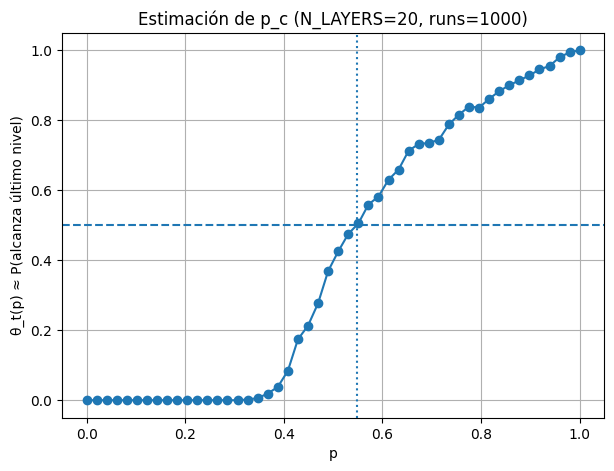

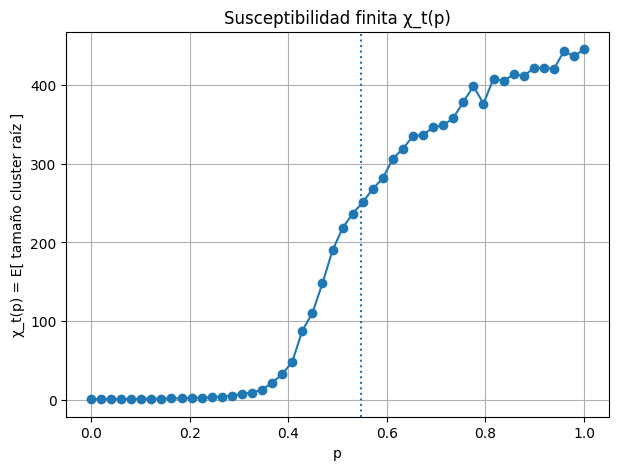

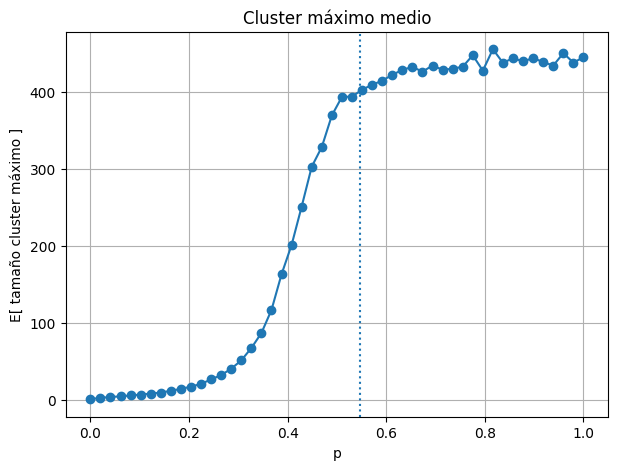

In [3]:
# =========================================================
#   Percolación en Triangulaciones Causales (GW + Spine)
#   Implementación fiel al examen con pasos g, r, s + batch
#   Métricas: p_crítico, χ_t(p), cluster máximo medio
# =========================================================
# Requisitos: numpy, matplotlib
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

# ---------------------------------------------------------
# 0) UTILIDADES TEÓRICAS
# ---------------------------------------------------------
# En el examen, la triangulación causal crítica se genera a partir
# de un árbol de Galton–Watson condicionado (spine decomposition):
#   - La "espina" (root actual en cada nivel) tiene descendencia ~ ρ_k
#   - Los demás vértices (no-spine) tienen descendencia ~ p_k
#   - El nuevo spine se elige uniformemente entre los hijos del spine
#
# Percolación Bernoulli:
#   - Cada arista (del strip y del anillo) se abre con probabilidad p
#   - r-step: aplicar Bernoulli(p) en TIEMPO y AUXILIARES del strip i->i+1
#   - s-step: aplicar Bernoulli(p) en ESPACIO (anillo) del nivel i+1
#   - La conectividad efectiva se refleja en las etiquetas de "cluster"
# ---------------------------------------------------------

def sample_pk(rng: np.random.Generator) -> int:
    """
    p_k = 1/2^{k+1}, k >= 0  (geométrica con p=1/2, soporte incluye 0)
    Implementación: Geometric(0.5) - 1
    """
    return rng.geometric(p=0.5) - 1

def sample_rho(rng: np.random.Generator) -> int:
    """
    ρ_k = k / 2^{k+1}, k >= 1  (sesgada por tamaño; 'size-biased')
    Muestreo por inversa de la CDF: F(n) = 1 - (n+2)/2^{n+1}.
    >>> La espina NUNCA tiene 0 hijos (k>=1), crucial para no-extinción.
    """
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

class DSU:
    """
    Disjoint Set Union (Union-Find) para fusionar componentes (clusters).
    - find: path compression
    - union: union by rank
    """
    def __init__(self, n: int):
        self.parent = list(range(n))
        self.rank = [0]*n
        self.size = [1]*n
    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x
    def union(self, a: int, b: int):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb; self.size[rb] += self.size[ra]
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra; self.size[ra] += self.size[rb]
        else:
            self.parent[rb] = ra; self.rank[ra] += 1; self.size[ra] += self.size[rb]
    def __len__(self):
        return len(self.parent)

# ---------------------------------------------------------
# 1) g–step: GENERACIÓN por espina (como en el examen)
# ---------------------------------------------------------
# Devuelve:
#   - layers[i]: IDs globales en el nivel i
#   - spine_ids[i]: ID del spine en el nivel i (o -1)
#   - splits[i]: [k_1,...,k_m] hijos por padre (strip i->i+1)
# Notas:
#   * Spine ~ ρ; no-spine ~ p_k
#   * Nuevo spine = hijo elegido uniformemente entre los del spine
# ---------------------------------------------------------

def generate_layers_with_splits(n_layers: int, rng: np.random.Generator):
    layers = [[0]]             # nivel 0: raíz id 0
    spine_ids = [0]            # spine inicial = raíz
    splits: List[List[int]] = []
    next_id = 1

    # Nivel 0: raíz ~ ρ (nunca 0)
    k0 = sample_rho(rng)
    splits.append([k0])
    level1 = list(range(next_id, next_id + k0)); next_id += k0
    layers.append(level1)
    new_spine = level1[rng.integers(0, k0)] if k0 > 0 else -1
    spine_ids.append(new_spine)

    # Niveles siguientes
    for i in range(1, n_layers):
        parents = layers[i]
        split_i, next_level = [], []
        spine_id = spine_ids[i]
        for pid in parents:
            k = sample_rho(rng) if (pid == spine_id and spine_id != -1) else sample_pk(rng)
            split_i.append(k)
            children = list(range(next_id, next_id + k)); next_id += k
            next_level.extend(children)
        splits.append(split_i)
        layers.append(next_level)

        # Elegir nuevo spine si el spine actual tuvo hijos
        if spine_id != -1:
            idx_sp = parents.index(spine_id); k_sp = split_i[idx_sp]
            if k_sp > 0:
                start = sum(split_i[:idx_sp])
                new_spine = next_level[start + rng.integers(0, k_sp)]
            else:
                new_spine = -1
        else:
            new_spine = -1
        spine_ids.append(new_spine)

    return layers, spine_ids, splits

# ---------------------------------------------------------
# 2) TOPOLOGÍA DEL STRIP (para r-step) — tiempo y auxiliares
# ---------------------------------------------------------
# strip_edges(parents, children, k_list) genera:
#   - TIEMPO: (padre -> cada hijo) en el strip i->i+1
#   - AUXILIARES (en i+1): último hijo de j con primer hijo del
#     siguiente padre con hijos (cierre circular), como en el examen.
# ---------------------------------------------------------

def partition_children(children: List[int], k_list: List[int]) -> List[List[int]]:
    groups, pos = [], 0
    for k in k_list:
        groups.append(children[pos:pos+k]); pos += k
    return groups

def strip_edges(parents: List[int], children: List[int], k_list: List[int]):
    time_e, aux_e = [], []
    if not parents or not children:
        return time_e, aux_e
    groups = partition_children(children, k_list)
    # Tiempo
    for j, p in enumerate(parents):
        for c in groups[j]:
            time_e.append((p, c))
    # Auxiliares (circular entre grupos contiguos con hijos)
    m = len(parents)
    if m >= 2:
        for j in range(m):
            if not groups[j]: continue
            last_c = groups[j][-1]
            s = (j+1) % m
            while s != j and not groups[s]:
                s = (s+1) % m
            if s != j and groups[s]:
                aux_e.append((last_c, groups[s][0]))
    return time_e, aux_e

# ---------------------------------------------------------
# 3) r–step: Bernoulli(p) en TIEMPO + AUXILIARES del strip
# ---------------------------------------------------------
# Teoría (examen):
#   - TIEMPO abierto => el hijo HEREDA la etiqueta del padre
#   - AUX abierta     => fusiona hijos de padres contiguos (en i+1)
# Implementación:
#   - v_prev: etiquetas en nivel i
#   - v_next: etiquetas preliminares en nivel i+1 tras r-step
#   - DSU local sobre i+1 para fusionar por auxiliares
# ---------------------------------------------------------
# NOTA: Esta función ya no es necesaria para la conectividad global
#       ya que el DSU global se construye en run_one_global_dsu.
#       La mantenemos si se necesita la lógica de etiquetas locales
#       por algún otro motivo (ej. visualización por nivel).
# def r_step_update(...): ...


# ---------------------------------------------------------
# 4) s–step: Bernoulli(p) en ESPACIO (anillo) del nivel i+1
# ---------------------------------------------------------
# Teoría (examen):
#   - Se recorren vecinos en el anillo; cada borde se abre con prob. p
#   - Si abre, se fusionan sus etiquetas (segunda actualización)
# ---------------------------------------------------------
# NOTA: Esta función ya no es necesaria para la conectividad global
#       ya que el DSU global se construye en run_one_global_dsu.
# def s_step_update(...): ...


# ---------------------------------------------------------
# 5) UNA SIMULACIÓN COMPLETA (g + r + s) y mediciones
#    MODIFICADO: Construye DSU global basado en aristas abiertas
# ---------------------------------------------------------

@dataclass
class SimResult:
    layers: List[List[int]]
    # cluster_labels ya no es la fuente principal de conectividad global
    # cluster_labels: List[List[int]]
    global_dsu: DSU
    node_to_dsu_idx: Dict[Tuple[int, int], int]


def run_one_global_dsu(n_layers: int, p: float, rng: np.random.Generator) -> SimResult:
    # g-step (generación de la estructura)
    layers, spine_ids, splits = generate_layers_with_splits(n_layers, rng)

    # Inicializar DSU global y mapeo nodo -> índice DSU
    all_nodes_list: List[Tuple[int, int]] = []
    for d, lvl in enumerate(layers):
        for gid in lvl:
            all_nodes_list.append((d, gid))

    total_nodes = len(all_nodes_list)
    global_dsu = DSU(total_nodes)
    node_to_dsu_idx = {node: i for i, node in enumerate(all_nodes_list)}

    # Aplicar percolación y actualizar DSU global nivel a nivel
    # Nivel 0: raíz (ya en DSU)
    # No hay percolación en el nivel 0

    # Strip por strip (nivel i a i+1)
    for i in range(len(layers) - 1):
        parents = layers[i]
        children = layers[i+1]
        k_list = splits[i] if i < len(splits) else [0] * len(parents)

        # 2) Topología del Strip y Aristas Abiertas
        t_e, a_e = strip_edges(parents, children, k_list)

        # r-step: Bernoulli(p) en TIEMPO + AUXILIARES del strip (i -> i+1)
        # Fusionar en el DSU global si la arista abre

        # TIEMPO: (padre -> hijo)
        for (p_id, c_id) in t_e:
            if rng.random() < p:
                # Arista abierta: fusionar padre en nivel i con hijo en nivel i+1
                p_node = (i, p_id)
                c_node = (i+1, c_id)
                if p_node in node_to_dsu_idx and c_node in node_to_dsu_idx:
                     global_dsu.union(node_to_dsu_idx[p_node], node_to_dsu_idx[c_node])

        # AUXILIARES (en i+1): (hijo1 -> hijo2)
        for (c1, c2) in a_e:
             if rng.random() < p:
                # Arista abierta: fusionar hijo1 con hijo2, ambos en nivel i+1
                c1_node = (i+1, c1)
                c2_node = (i+1, c2)
                if c1_node in node_to_dsu_idx and c2_node in node_to_dsu_idx:
                    global_dsu.union(node_to_dsu_idx[c1_node], node_to_dsu_idx[c2_node])


        # s-step: Bernoulli(p) en ESPACIO (anillo) del nivel i+1
        if len(children) > 1:
            for j in range(len(children)):
                c1_id = children[j]
                c2_id = children[(j + 1) % len(children)]
                if rng.random() < p:
                    # Arista abierta: fusionar c1 con c2, ambos en nivel i+1
                    c1_node = (i+1, c1_id)
                    c2_node = (i+1, c2_id)
                    if c1_node in node_to_dsu_idx and c2_node in node_to_dsu_idx:
                         global_dsu.union(node_to_dsu_idx[c1_node], node_to_dsu_idx[c2_node])


    # Las cluster_labels originales ya no son necesarias para la conectividad global
    # (pero podrían ser útiles para visualización local por nivel si se desea)
    # Por ahora, las omitimos en el resultado para evitar confusión
    # cluster_labels = [] # Puedes generar etiquetas locales si las necesitas para algo

    return SimResult(layers, global_dsu, node_to_dsu_idx)

# Medidas:
#   - root_cluster_size: tamaño del cluster que contiene a la raíz
#   - max_cluster_size:  tamaño del cluster más grande del grafo
#   - spanning: ¿el cluster de la raíz alcanza el último nivel?
#    MODIFICADO: Usa el DSU global
def measure_run_global_dsu(sim: SimResult) -> Tuple[int, int, bool]:
    global_dsu = sim.global_dsu
    node_to_dsu_idx = sim.node_to_dsu_idx
    layers = sim.layers

    # Tamaños de componentes directamente del DSU global
    # El DSU.size array ya tiene los tamaños para cada raíz de componente
    # Debemos iterar sobre todos los nodos y obtener el tamaño de su raíz
    comp_size: Dict[int, int] = {}
    # Iterar sobre todos los nodos que fueron mapeados a un índice DSU
    # Esto es más seguro que iterar sobre global_dsu.__len__() si no todos los nodos fueron mapeados
    for node, idx in node_to_dsu_idx.items():
         root = global_dsu.find(idx)
         comp_size[root] = global_dsu.size[root] # Usar el tamaño precalculado por DSU


    # Cluster de la raíz
    root_node = (0, layers[0][0]) # La raíz es (nivel 0, id 0)
    root_size = 0
    spanning = False

    if root_node in node_to_dsu_idx:
        root_dsu_idx = node_to_dsu_idx[root_node]
        root_comp_root = global_dsu.find(root_dsu_idx)
        root_size = comp_size.get(root_comp_root, 0) # Usar get por si la raíz no está mapeada (error)

        # ¿Alcanza el último nivel?
        last_d = len(layers) - 1
        if last_d >= 0 and last_d < len(layers): # Asegurar que el último nivel existe y es válido
            for gid in layers[last_d]:
                last_layer_node = (last_d, gid)
                if last_layer_node in node_to_dsu_idx:
                    last_layer_dsu_idx = node_to_dsu_idx[last_layer_node]
                    if global_dsu.find(last_layer_dsu_idx) == root_comp_root:
                        spanning = True
                        break # Encontramos un nodo en el último nivel conectado a la raíz


    # Cluster máximo
    max_size = max(comp_size.values()) if comp_size else 0

    return root_size, max_size, spanning

# ---------------------------------------------------------
# 6) EXPERIMENTO BATCH: 1000 simulaciones por p y p_crítico
#    MODIFICADO: Usa las nuevas funciones run_one y measure_run
# ---------------------------------------------------------

def run_batch(P_GRID, NUM_RUNS=1000, N_LAYERS=12, SEED=2025):
    """
    Corre NUM_RUNS simulaciones por cada p en P_GRID.
    Devuelve un array con columnas:
      [ p, chi_hat(p), max_mean(p), theta_hat(p) ]
    donde:
      - chi_hat(p)   = E[tamaño del cluster de la raíz]
      - max_mean(p)  = E[tamaño cluster máximo]
      - theta_hat(p) = P( la raíz alcanza el último nivel )
    """
    rng_master = np.random.default_rng(SEED)
    stats = []
    for p in P_GRID:
        root_sizes, max_sizes, spans = [], [], 0
        for _ in range(NUM_RUNS):
            rng = np.random.default_rng(rng_master.integers(0, 2**31-1))
            # Usar la nueva función run_one_global_dsu
            sim = run_one_global_dsu(N_LAYERS, p, rng)
            # Usar la nueva función measure_run_global_dsu
            rs, ms, sp = measure_run_global_dsu(sim)
            root_sizes.append(rs); max_sizes.append(ms); spans += int(sp)
        chi = float(np.mean(root_sizes))
        max_mean = float(np.mean(max_sizes))
        theta = spans/NUM_RUNS
        stats.append((p, chi, max_mean, theta))
    return np.array(stats, float)

def estimate_pc_from_crossing(stats: np.ndarray) -> float:
    """
    Estima p_crítico como el primer cruce de theta_hat(p) con 0.5,
    usando interpolación lineal entre los dos puntos adyacentes.
    """
    p = stats[:,0]; th = stats[:,3]
    # índice del primer punto con theta >= 0.5
    idxs = np.where(th >= 0.5)[0]
    if len(idxs) == 0:
        # Si theta nunca alcanza 0.5, p_c > p[-1]
        return p[-1] if len(p) > 0 else np.nan # Retorna el último p o NaN si no hay puntos
    idx = idxs[0]
    if idx == 0:
        # Si theta >= 0.5 en el primer punto, p_c <= p[0]
        return p[0]
    p0, t0 = p[idx-1], th[idx-1]
    p1, t1 = p[idx], th[idx]
    if t1 == t0:
        return p1 # Evitar división por cero si theta es constante
    # Interpolación lineal
    return p0 + (0.5 - t0) * (p1 - p0) / (t1 - t0)

# ---------------------------------------------------------
# 7) DEMO: Ejecuta, estima p_c, grafica y (opcional) guarda CSV
#    MODIFICADO: Usa las nuevas funciones
# ---------------------------------------------------------

if __name__ == "__main__":
    # Parámetros del experimento (ajústalos a gusto)
    N_LAYERS = 20           # profundidad de la triangulación (truncación)
    NUM_RUNS = 1000         # simulaciones por punto
    P_GRID   = np.linspace(0.0, 1, 50)  # rango de p con paso 0.02
    SAVE_CSV = False        # True para guardar CSV

    # 1) Barrido de p y métricas (usando la nueva función)
    rng_master = np.random.default_rng(1234) # Mismo seed para reproducibilidad
    stats = []
    for p in P_GRID:
        root_sizes, max_sizes, spans = [], [], 0
        for _ in range(NUM_RUNS):
            rng = np.random.default_rng(rng_master.integers(0, 2**31-1))
            # Usar la nueva función run_one_global_dsu
            sim = run_one_global_dsu(N_LAYERS, p, rng)
            # Usar la nueva función measure_run_global_dsu
            rs, ms, sp = measure_run_global_dsu(sim)
            root_sizes.append(rs); max_sizes.append(ms); spans += int(sp)
        chi = float(np.mean(root_sizes))
        max_mean = float(np.mean(max_sizes))
        theta = spans/NUM_RUNS
        stats.append((p, chi, max_mean, theta))
    stats = np.array(stats, float) # Convertir a numpy array al final

    # 2) Estimar p_c por cruce 0.5 de theta_hat(p)
    # Esta función debería ahora trabajar correctamente si theta_hat(0) es 0
    pc_hat = estimate_pc_from_crossing(stats)

    # 3) Métricas en p_c (repetimos 1000 simulaciones sólo en p_c)
    # Asegurarse de que pc_hat no sea NaN o inf antes de usarlo
    if np.isfinite(pc_hat):
        stats_pc = run_batch(np.array([pc_hat]), NUM_RUNS, N_LAYERS, SEED=5678)
        chi_pc, max_pc, theta_pc = stats_pc[0,1], stats_pc[0,2], stats_pc[0,3]
    else:
        # Manejar caso donde pc_hat no pudo ser estimado (ej. theta nunca cruza 0.5)
        print("No se pudo estimar p_c por cruce 0.5.")
        chi_pc, max_pc, theta_pc = np.nan, np.nan, np.nan # Usar NaN para indicar no calculado


    # ---- Impresión de resultados clave ----
    print(f"p_c (cruce 0.5) ≈ {pc_hat:.4f}")
    print(f"χ_t(p_c) (cluster medio raíz) ≈ {chi_pc:.2f}")
    print(f"Cluster máximo medio en p_c ≈ {max_pc:.2f}")
    print(f"θ_t(p_c) (chequeo) ≈ {theta_pc:.3f}")

    # 4) GRÁFICAS (una por figura) - El código de graficación es el mismo
    # θ_t(p): prob. de alcanzar el último nivel (proxy de percolación)
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,3], marker='o')
    plt.axhline(0.5, linestyle='--')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("θ_t(p) ≈ P(alcanza último nivel)")
    plt.title(f"Estimación de p_c (N_LAYERS={N_LAYERS}, runs={NUM_RUNS})")
    plt.grid(True)
    plt.show()

    # χ_t(p): tamaño medio del cluster de la raíz
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,1], marker='o')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("χ_t(p) = E[ tamaño cluster raíz ]")
    plt.title("Susceptibilidad finita χ_t(p)")
    plt.grid(True)
    plt.show()

    # Cluster máximo medio
    plt.figure(figsize=(7,5))
    plt.plot(stats[:,0], stats[:,2], marker='o')
    plt.axvline(pc_hat, linestyle=':')
    plt.xlabel("p"); plt.ylabel("E[ tamaño cluster máximo ]")
    plt.title("Cluster máximo medio")
    plt.grid(True)
    plt.show()

    # 5) (Opcional) Guardar CSV - El código es el mismo
    if SAVE_CSV:
        import csv
        with open("batch_percolation_results.csv", "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["p", "chi_hat_root", "max_cluster_mean", "theta_hat"])
            for row in stats:
                w.writerow([f"{row[0]:.6f}", f"{row[1]:.6f}", f"{row[2]:.6f}", f"{row[3]:.6f}"])
        print("CSV guardado en batch_percolation_results.csv")

In [2]:
# Explorar una simulación con p=0 para entender el comportamiento
N_LAYERS_EXPLORE = 20 # Usamos el mismo número de capas que en el experimento batch
SEED_EXPLORE = 9999
p_explore = 0.0

rng_explore = np.random.default_rng(SEED_EXPLORE)

# Ejecutar una sola simulación con p=0
sim_explore = run_one(N_LAYERS_EXPLORE, p_explore, rng_explore)

print(f"Explorando simulación con p = {p_explore} y N_LAYERS = {N_LAYERS_EXPLORE}\n")

# Mostrar la estructura de las capas (IDs globales)
print("Estructura de las capas (IDs globales):")
for i, layer in enumerate(sim_explore.layers):
    print(f"  Nivel {i}: {layer}")
print("-" * 30)

# Mostrar las etiquetas de clúster por nivel
print("Etiquetas de clúster por nivel:")
for i, labels in enumerate(sim_explore.cluster_labels):
    print(f"  Nivel {i}: {labels}")
print("-" * 30)

# Opcional: Ejecutar measure_run en esta simulación para confirmar el resultado
root_size, max_size, spanning = measure_run(sim_explore)
print(f"Resultados de measure_run para esta simulación:")
print(f"  Tamaño del clúster de la raíz: {root_size}")
print(f"  Tamaño del clúster máximo: {max_size}")
print(f"  ¿El clúster de la raíz alcanza el último nivel? (Spanning): {spanning}")

Explorando simulación con p = 0.0 y N_LAYERS = 20

Estructura de las capas (IDs globales):
  Nivel 0: [0]
  Nivel 1: [1, 2, 3, 4, 5]
  Nivel 2: [6, 7, 8, 9, 10, 11]
  Nivel 3: [12, 13, 14, 15, 16, 17]
  Nivel 4: [18, 19, 20, 21, 22, 23, 24]
  Nivel 5: [25, 26, 27, 28, 29, 30, 31]
  Nivel 6: [32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
  Nivel 7: [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
  Nivel 8: [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
  Nivel 9: [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  Nivel 10: [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
  Nivel 11: [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
  Nivel 12: [143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]
  Nivel 13: [168, 16